# Recommender System

In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Familiarization

First, we will load the entire dataset and visualize it to get a first look at what we are dealing with. We have decided to visualize the given data as a matrix where on column i we can see which people the person with id i liked/disliked by checking each line and putting either a green dot if they liked the person with id j (line j), or a red dot if they disliked them.

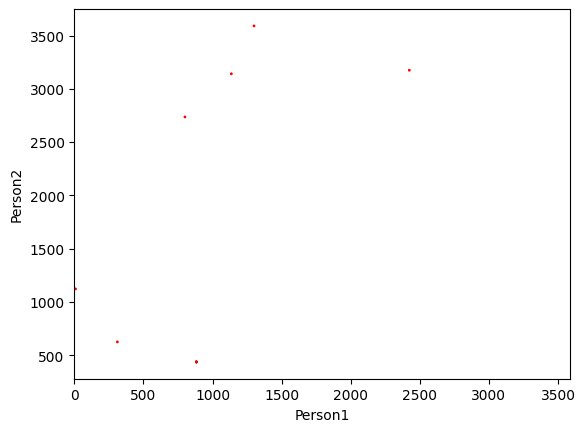

In [140]:
train_file_path = 'simple_train.csv'

pd.set_option('display.max_rows', None)
train_data = pd.read_csv(train_file_path, delimiter=',', skipinitialspace= True)
#dropping the column related to matches as is mentioned in the assignment description
train_data = train_data.drop('is_match',axis=1)

def visualize_data(df, window=None, title=None):
    if window is None:
        start_index = 0
        end_index = train_data['user_to_id'].max()
    else:
        start_index, end_index = window
    plt.scatter(df['user_from_id'], df['user_to_id'], c=df['is_like'].map({True: 'green', False: 'red'}),s=1)

    plt.xlim(start_index,end_index)

    plt.xlabel('Person1')
    plt.ylabel('Person2')

    if title is not None:
        plt.title(title)

    plt.show()

visualize_data(train_data)

On a first glance, one can easily see that users with id greater than ~2500 rate(like/dislike) a lot less than the others. There are also certain groups(intervals of columns) of people that like a lot/dislike a lot. To show a couple of examples, we will plot a few smaller window of columns that demonstrate users that mostly dislike others, and also print a list of the people who have only ever liked others, without any dislikes.

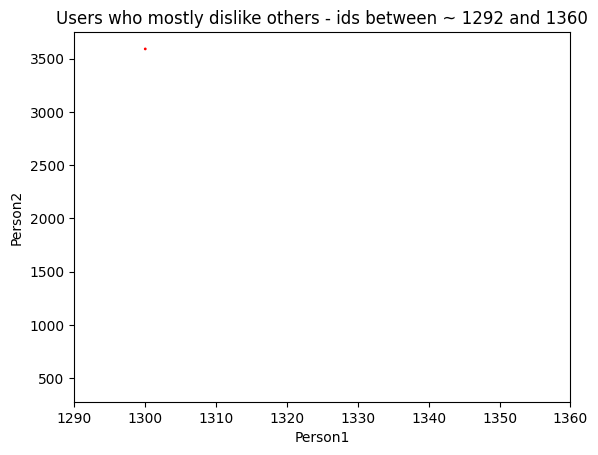

List of the ids of users who only liked others.


In [141]:
visualize_data(train_data, (1290,1360), "Users who mostly dislike others - ids between ~ 1292 and 1360")

id_counts = list(train_data[(train_data['is_like'] == True) | (train_data['is_like'] == False)]['user_from_id'].value_counts().items())
filtered_data = train_data[train_data['is_like'] == True]
like_counts = list(filtered_data['user_from_id'].value_counts().items())

all_likes_tuples = list(set(id_counts) & set(like_counts))
all_likes = [v[0] for v in all_likes_tuples]
print("List of the ids of users who only liked others.")
for id in all_likes:
    print(id)

Thus, we can observe that multiple types of people exist in our dataset. There are also examples of intervals where a lot of users did not have any type of interaction, i.e between 1250 and 1300, most users seem to not have many if any interactions at all.

# NMF-based recommender system

We will now apply our NMF algorithm on the dataset in order to then reconstruct the matrix for a proper recommender system. But first, we will have to do some preprocessing on our training dataframe. After a lot of trial and error, we have decided to:
- remove the duplicate lines, only keeping unique instances of lines
- remove rows where a user first liked a person and then disliked them, or the other way around(due to inconsistency in data) Example: user 1 liked user 2, and then disliked them afterwards. We are deleting both rows.
- remove ids of users who have never liked someone, meaning either only dislikes or no interactions at all
- remove ids of people who have less than a certain threshold of interactions(times they appear in the dataframe) 

In our tests, the removal of such outliers has shown to improve our algorithm's accuracy and, at the same time, make a lot of sense to us in order to maintain consistency and fairness in our data.
### Preprocessing

In [142]:
#removing duplicate lines 
print(train_data)
train_data = train_data.drop_duplicates()
#removing inconsistend ids(described above)
mask = train_data.duplicated(subset=['user_from_id', 'user_to_id'],keep=False)
train_data = train_data[~mask].reset_index(drop=True)
print(train_data)


   user_from_id  user_to_id  is_like
0          1136        3141    False
1          2424        3174    False
2          1300        3590    False
3           800        2736    False
4           883         437     True
5           311         625    False
6             8        1122    False
7           883         437     True
8           883         437    False
9           883         437    False
   user_from_id  user_to_id  is_like
0          1136        3141    False
1          2424        3174    False
2          1300        3590    False
3           800        2736    False
4           883         437     True
5           311         625    False
6             8        1122    False
8           883         437    False
   user_from_id  user_to_id  is_like
0          1136        3141    False
1          2424        3174    False
2          1300        3590    False
3           800        2736    False
4           311         625    False
5             8        1122    False
